In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import math
import scipy.optimize
import scipy.special
import time
import pickle


from conc_ineq.hoeffding import adaptive_hoeffding_seq
from conc_ineq.bernstein import empirical_bernstein_seq, hrms_bernstein_seq, hrms_bernstein_gamma_seq
from conc_ineq.bentkus import adaptive_bentkus_seq, adaptive_bentkus_seq_untruncated, adaptive_bentkus_stopping


class ArmConfSeqOracle:
    """ Oracle to hold the confidence sequences computed for observations in one arm
    
        Attributes:
            Y - observations
            conf_seq_func - function to compute the lower/upper confidence term and radius of CI
            delta - failure probability of the conf seq
            L_top, U_top, R_top - lower, upper confidence terms and radius when this arm 
                                  is selected as the top arm
            L, U, R - lower, upper confidence terms and radius when this arm is NOT selected 
                      as the top arm
    """
    def __init__(self, Y, conf_seq_func, delta=0.05):
        self.Y = Y
        self.conf_seq_func = conf_seq_func
        self.delta = 0.05
        self.L_top, self.U_top, self.R_top = None, None, None
        self.L, self.U, self.R = self.conf_seq_func(self.Y, self.delta/2.0)
       
    def update(self, set_arm_size):
        self.L_top, self.U_top, self.R_top = self.conf_seq_func(self.Y, self.delta/2.0/(set_arm_size-1))
        
def best_arm(Y, conf_seq_func, delta=0.05):  
    K = len(Y)
    assert K >= 2
    arms = set(range(K))
    num_pulls, mu_hats = np.zeros(K, dtype=np.int32), np.zeros(K)
    
    conf_seqs = {}
    for ii in range(K):
        conf_seqs[ii] = ArmConfSeqOracle(Y=Y[ii], conf_seq_func=conf_seq_func, delta=delta)      
    
    # We need to pull each arm once since unsampled arms 
    # will have a CI with infinite width
    for ii in range(K):
        mu_hats[ii] = Y[ii][0]
        num_pulls[ii] += 1
        
    # Elimination Loop
    sample_arm, last_iter_top_arm = -1, -1
    pulls = list(range(K))
    max_pulls = Y[0].size
    L, U, radius  = {ii: [] for ii in range(K)}, {ii: [] for ii in range(K)}, {ii: [] for ii in range(K)}
    while len(arms) > 1:
        
        # termination check
        if np.sum(num_pulls) == max_pulls:
            print('Pulled too many times, quitting....')
            break
            
        # find the best arm so far
        top_arm = list(arms)[np.argmax(mu_hats[list(arms)])]
        if top_arm != last_iter_top_arm: 
            conf_seqs[top_arm].update(len(arms))
            
        # compute confidence interval
        for ind in arms:
            nn = num_pulls[ind]
            if ind == top_arm:
                ll, uu, rr = conf_seqs[ind].L_top[nn-1], conf_seqs[ind].U_top[nn-1], conf_seqs[ind].R_top[nn-1]    
            else:
                ll, uu, rr = conf_seqs[ind].L[nn-1], conf_seqs[ind].U[nn-1], conf_seqs[ind].R[nn-1]
            L[ind].append(ll)
            U[ind].append(uu)
            radius[ind].append(rr)
            
        # sampling
        width = [radius[ii][-1] for ii in arms]
        max_width = np.max(width)
        if np.sum(width >= max_width) > 1:
            max_width_arms = np.array(list(arms))[width >= max_width]
            sample_arm = max_width_arms[np.argmin(mu_hats[max_width_arms])]
        else:
            sample_arm = list(arms)[np.argmax(width)]
        num_pulls[sample_arm] += 1
        mu_hats[sample_arm] = np.mean(Y[sample_arm][:num_pulls[sample_arm]])
        pulls.append(sample_arm)
        
        # elimination
        removable = []
        for ind in arms:
            if ind is not top_arm and U[ind][-1] < L[top_arm][-1]:
                removable.append(ind)
                print('Iter {}, Arm {} out'.format(np.sum(num_pulls), ind))               
        if len(removable):
            for ind in removable:
                arms.remove(ind)
            if len(arms) > 1:
                conf_seqs[top_arm].update(set_arm_size=len(arms))
         
        last_iter_top_arm = top_arm
        
    return ( np.sum(num_pulls), num_pulls, np.array(pulls), 
           np.array(mu_hats), 
            {ii: np.array(L[ii]) for ii in range(K)},
            {ii: np.array(U[ii]) for ii in range(K)},
            {ii: np.array(radius[ii]) for ii in range(K)}
           )


## Best Arm Experiment

In [ ]:
def gen_data_func(mu, n):
    return np.random.binomial(1, p=mu, size=n)

def conf_seq_func_ah(Y, delta):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_ah = adaptive_hoeffding_seq(N, delta / 2, upper=1, lower=0)
    return Ymean - f_ah / ns, Ymean + f_ah / ns, f_ah/ ns

def conf_seq_func_bn(Y, delta, eta=1.1, power=1.1):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_bn = empirical_bernstein_seq(Y, delta / 2, B=1., eta=eta, power=power, std_upper_bound = 1.)
    return Ymean - f_bn/ns, Ymean + f_bn/ns, f_bn/ns

def conf_seq_func_ho(Y, delta):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_ho = hrms_bernstein_seq(Y, delta / 2, std_upper_bound = 0.5)
    return Ymean - f_ho/ns, Ymean + f_ho/ns, f_ho/ns

def conf_seq_func_hrms(Y, delta):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_gamma = hrms_bernstein_gamma_seq(Y, delta / 2, L = 0.0, U = 1.0)
    return Ymean - f_gamma/ns, Ymean + f_gamma/ns, f_gamma/ns

def conf_seq_func_bk_variation(Y, delta, eta=1.1, power=1.1):
    mu_low, mu_up, Sn_low, Sn_up = adaptive_bentkus_seq(Y, delta, U=1, L=0, eta=eta, power=power)
    LL, UU, _, _ = adaptive_bentkus_seq_untruncated(Y, delta, U=1, L=0, eta=eta, power=power)
    return mu_low, mu_up, (UU - LL)/2.0

def run_best_arm_expr(K, max_pull=5000, ntrails=10):
    mus = np.zeros(K)
    for ii in range(K):
        mus[ii] = 1.0 - (ii / float(K))**0.6
    hardness = np.sum(1.0 / (mus[1:] - mus[0])**2)

    np.random.seed(0)
    AH, BK, HO, BN, HRMS = np.zeros(ntrails), np.zeros(ntrails), np.zeros(ntrails), np.zeros(ntrails), np.zeros(ntrails), 
    for rep in range(ntrails):
        print(f'Trail {rep}')
        Ys = [gen_data_func(mus[ii], max_pull) for ii in range(K)]
        print('AH')
        AH[rep], _, _, _, _, _, _,  = best_arm(Ys, conf_seq_func_ah, delta=0.05)
        print('BK')
        import time
        aa = time.time()
        BK[rep], _, _, _, _, _, _,  = best_arm(Ys, conf_seq_func_bk_variation, delta=0.05)
        print(time.time() - aa)
        print('HO')
        HO[rep], _, _, _, _, _,_,   = best_arm(Ys, conf_seq_func_ho, delta=0.05)
        print('BN')
        BN[rep], _, _, _, _, _,_,   = best_arm(Ys, conf_seq_func_bn, delta=0.05)
        print('HRMS')
        HRMS[rep], _, _, _, _, _,_, = best_arm(Ys, conf_seq_func_hrms, delta=0.05)
        
    return AH, BK, HO, BN, HRMS

In [ ]:
#AH, BK, HO, BN, HRMS = {}, {}, {}, {}, {}
#import pickle
#with open('./rsts.pickle', 'rb') as f:
#    AH, BK, HO, BN, HRMS] = pickle.load(f)
    
#print('%%%% 2 %%%%%')
#AH[2], BK[2], HO[2], BN[2], HRMS[2] = run_best_arm_expr(K=2, max_pull=600, ntrails=10)

#print('%%%% 3 %%%%%')
#AH[3], BK[3], HO[3], BN[3], HRMS[3] = run_best_arm_expr(K=3, max_pull=800, ntrails=10)

#print('%%%% 4 %%%%%')
#AH[4], BK[4], HO[4], BN[4], HRMS[4] = run_best_arm_expr(K=4, max_pull=1200, ntrails=10)

#print('%%%% 5 %%%%%')
#AH[5], BK[5], HO[5], BN[5], HRMS[5] = run_best_arm_expr(K=5, max_pull=1600, ntrails=10)

#print('%%%% 6 %%%%%')
#AH[6], BK[6], HO[6], BN[6], HRMS[6] = run_best_arm_expr(K=6, max_pull=2000, ntrails=10)

#AH[7], BK[7], HO[7], BN[7], HRMS[7] = run_best_arm_expr(K=7, max_pull=2400, ntrails=10)
#AH[8], BK[8], HO[8], BN[8], HRMS[8] = run_best_arm_expr(K=8, max_pull=2600, ntrails=10)
#AH[9], BK[9], HO[9], BN[9], HRMS[9] = run_best_arm_expr(K=9, max_pull=3000, ntrails=10)
#AH[10], BK[10], HO[10], BN[10], HRMS[10] = run_best_arm_expr(K=10, max_pull=3400, ntrails=10)
#AH[11], BK[11], HO[11], BN[11], HRMS[11] = run_best_arm_expr(K=11, max_pull=4000, ntrails=10)
#AH[12], BK[12], HO[12], BN[12], HRMS[12] = run_best_arm_expr(K=12, max_pull=4200, ntrails=10)

In [ ]:
import pickle
with open('./rsts.pickle', 'rb') as f:
    AH, BK, HO, BN, HRMS = pickle.load(f)
  
    
hardness = {}
Krange = range(2, 13)
for K in Krange:
    mus = np.zeros(K)
    for ii in range(K):
        mus[ii] = 1.0 - (ii / float(K))**0.6
    hardness[K] = np.sum(1.0 / (mus[1:] - mus[0])**2)
AH_rst = [np.mean(AH[K])/hardness[K] for K in Krange]
AH_std = [np.std(AH[K]/hardness[K])  for K in Krange]

BK_rst = [np.mean(BK[K])/hardness[K] for K in Krange]
BK_std = [np.std(AH[K]/hardness[K])  for K in Krange]

HO_rst = [np.mean(HO[K])/hardness[K] for K in Krange]
HO_std = [np.std(HO[K]/hardness[K])  for K in Krange]

BN_rst = [np.mean(BN[K])/hardness[K] for K in Krange]
BN_std = [np.std(BN[K]/hardness[K])  for K in Krange]

HRMS_rst = [np.mean(HRMS[K])/hardness[K] for K in Krange]
HRMS_std = [np.std(HRMS[K]/hardness[K])  for K in Krange]


plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 6))
plt.errorbar(Krange, BN_rst,   yerr=BN_std, color='b',   capsize=4)
plt.errorbar(Krange, HRMS_rst, yerr=HRMS_std, color='c', capsize=4)
plt.errorbar(Krange, HO_rst,   yerr=HO_std, color='m',   capsize=4)
plt.errorbar(Krange, AH_rst,   yerr=AH_std, color='k',   capsize=4)
plt.errorbar(Krange, BK_rst,   yerr=BK_std, color='r',   capsize=4)
plt.xlabel(r'$K$', fontsize=18)
plt.ylabel(r'$N$ (in units of H1)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(['E-Bernstein', 'HRMS-Bernstein', 'HRMS-Bernstein-GE', 'A-Hoeffding', 'A-Bentkus'], 
        fontsize=17, bbox_to_anchor=(1.01, 1.03), frameon=False, # ncol = 4,
        loc=1,          
)
plt.savefig('./figure/best_arm.pdf', bbox_inches='tight', pad_inches=0)

## AH vs Truncated AH

Iter 107, Arm 1 out
Iter 132, Arm 1 out


<IPython.core.display.Javascript object>


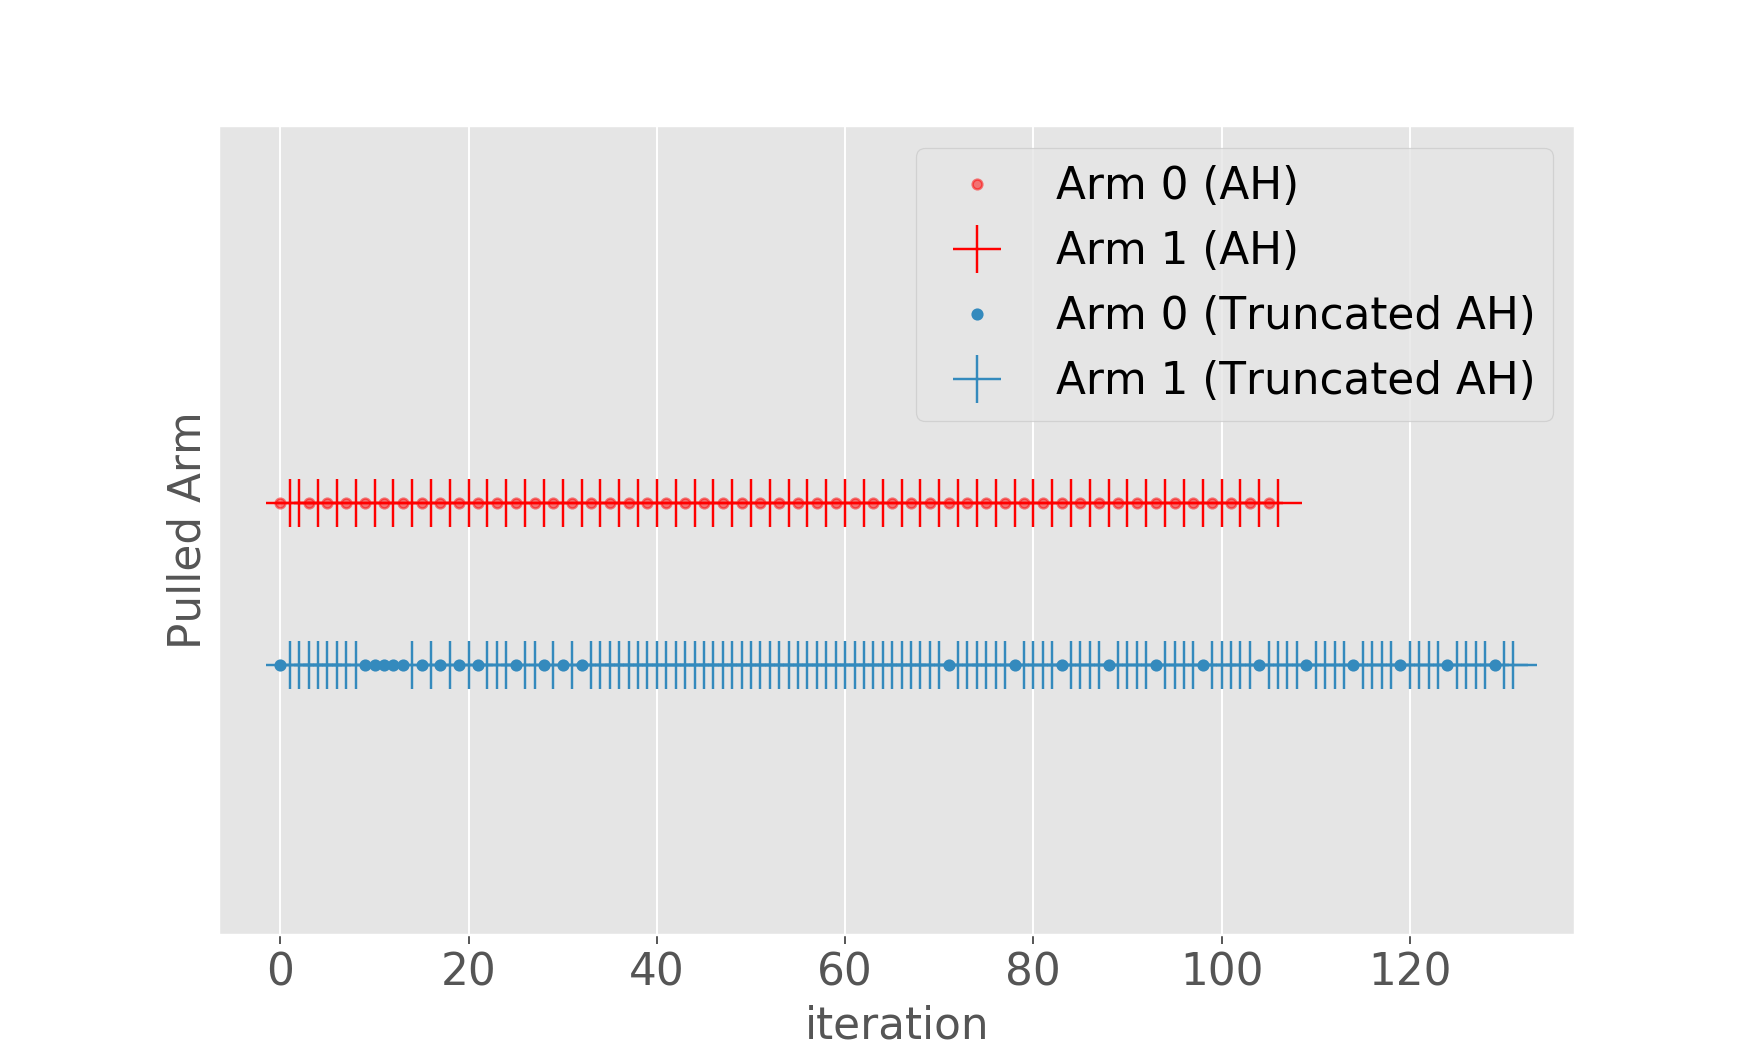

<IPython.core.display.Javascript object>


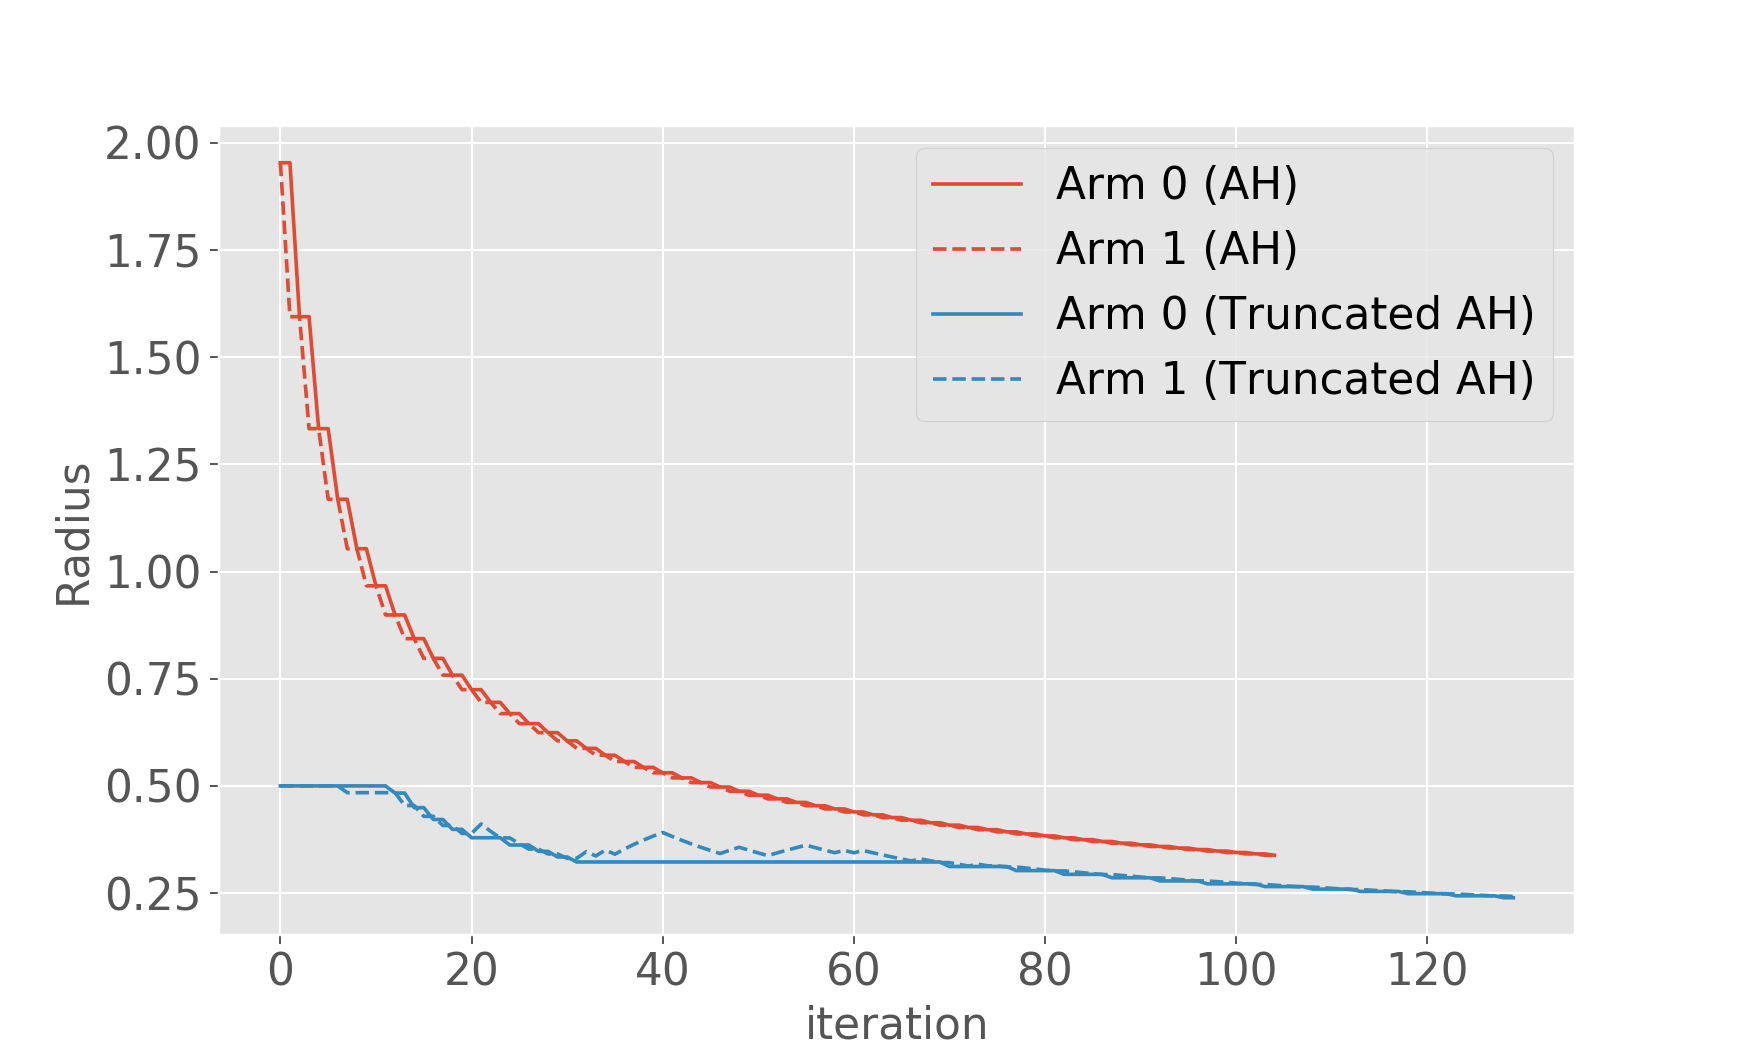

<IPython.core.display.Javascript object>


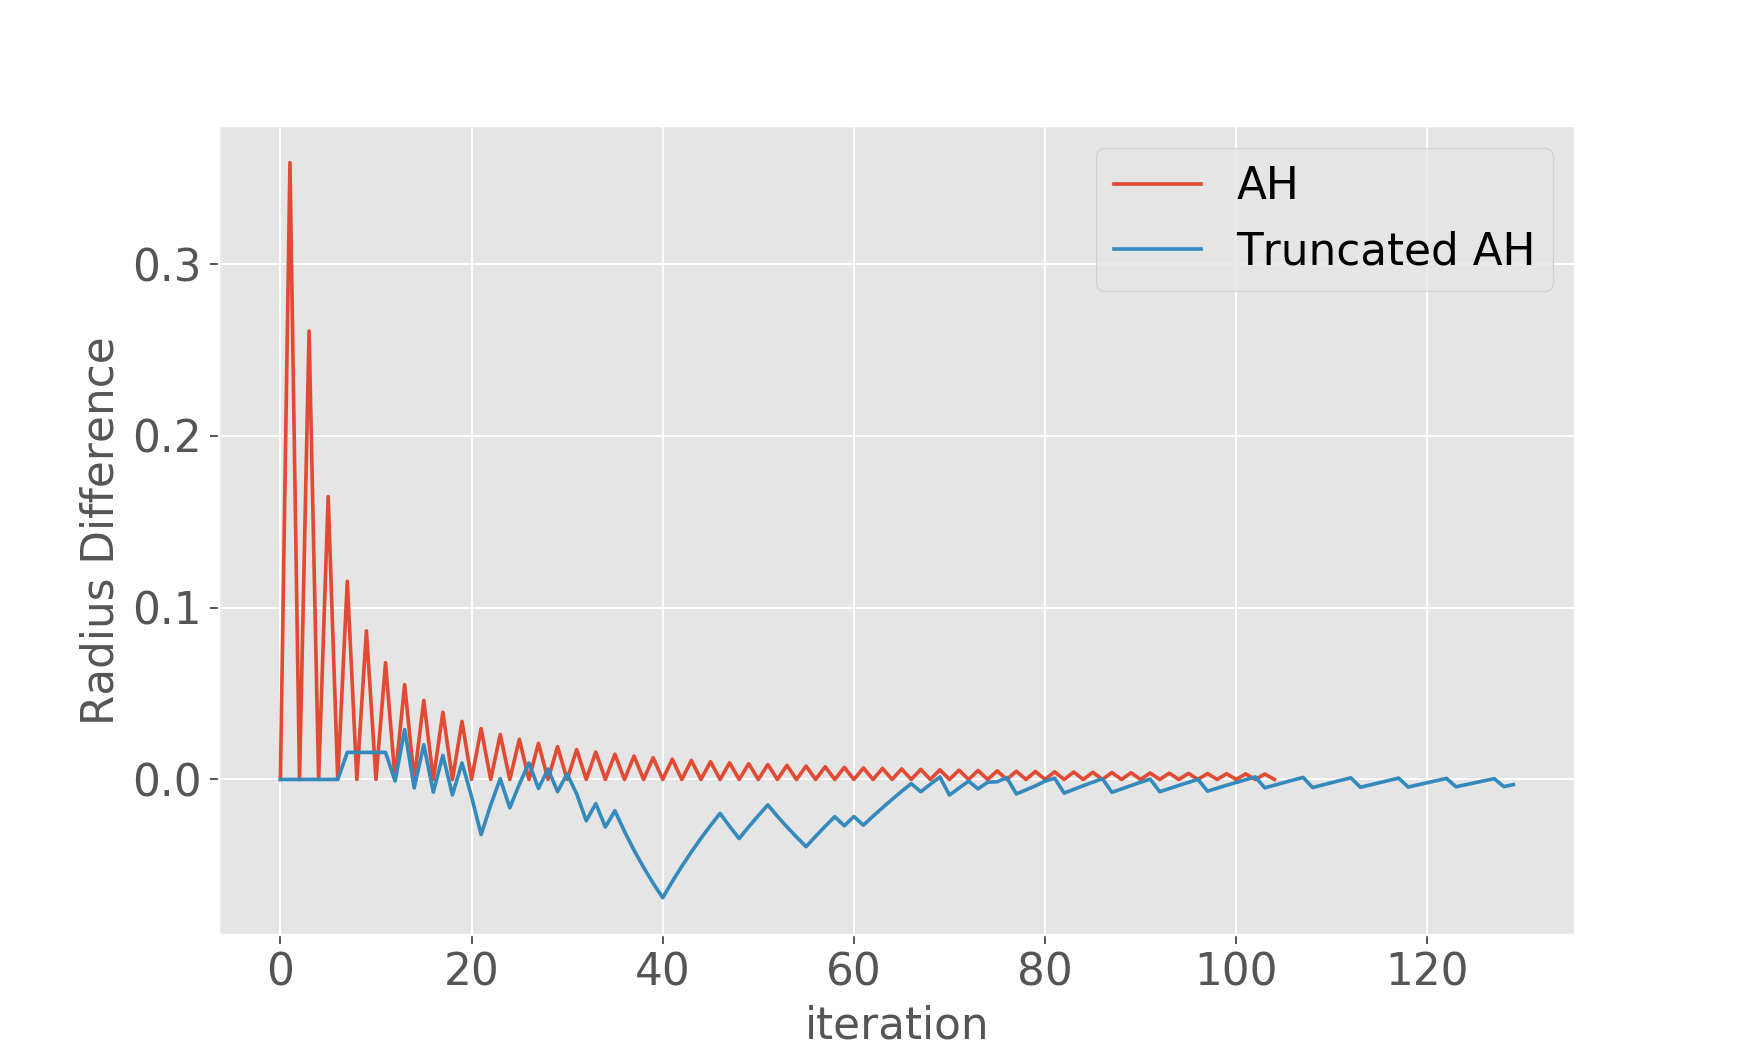

<IPython.core.display.Javascript object>


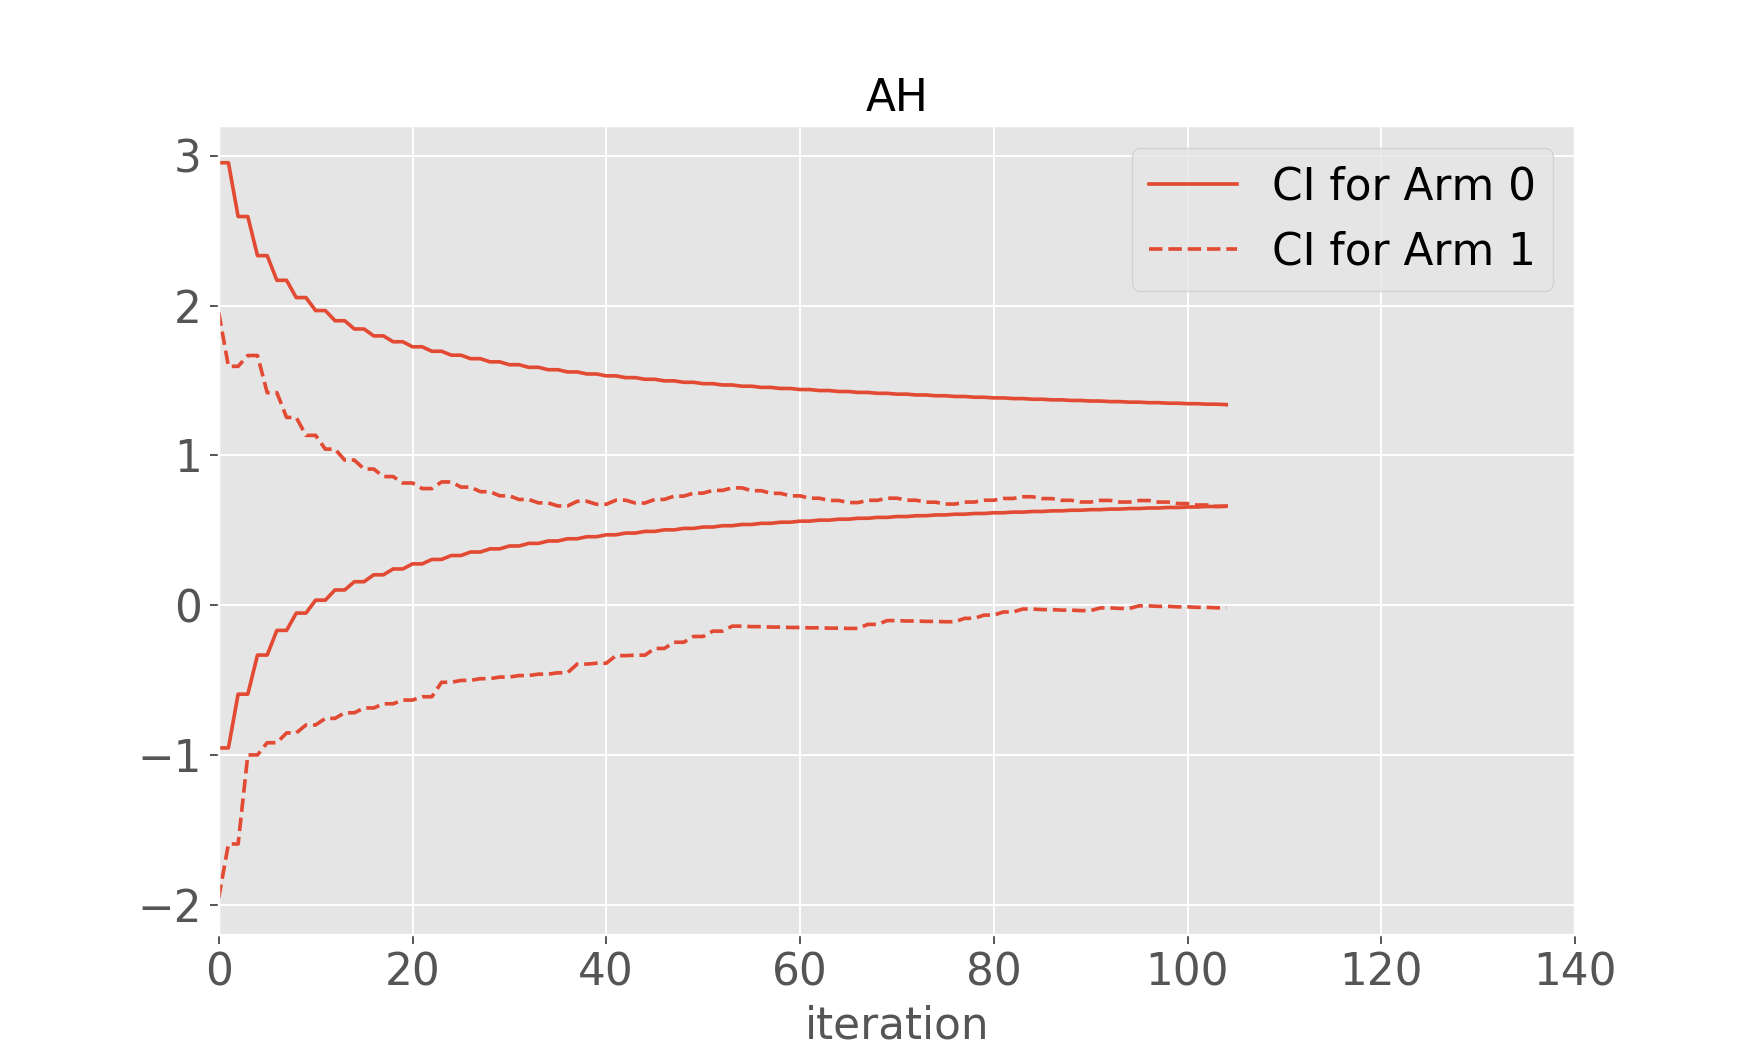

<IPython.core.display.Javascript object>


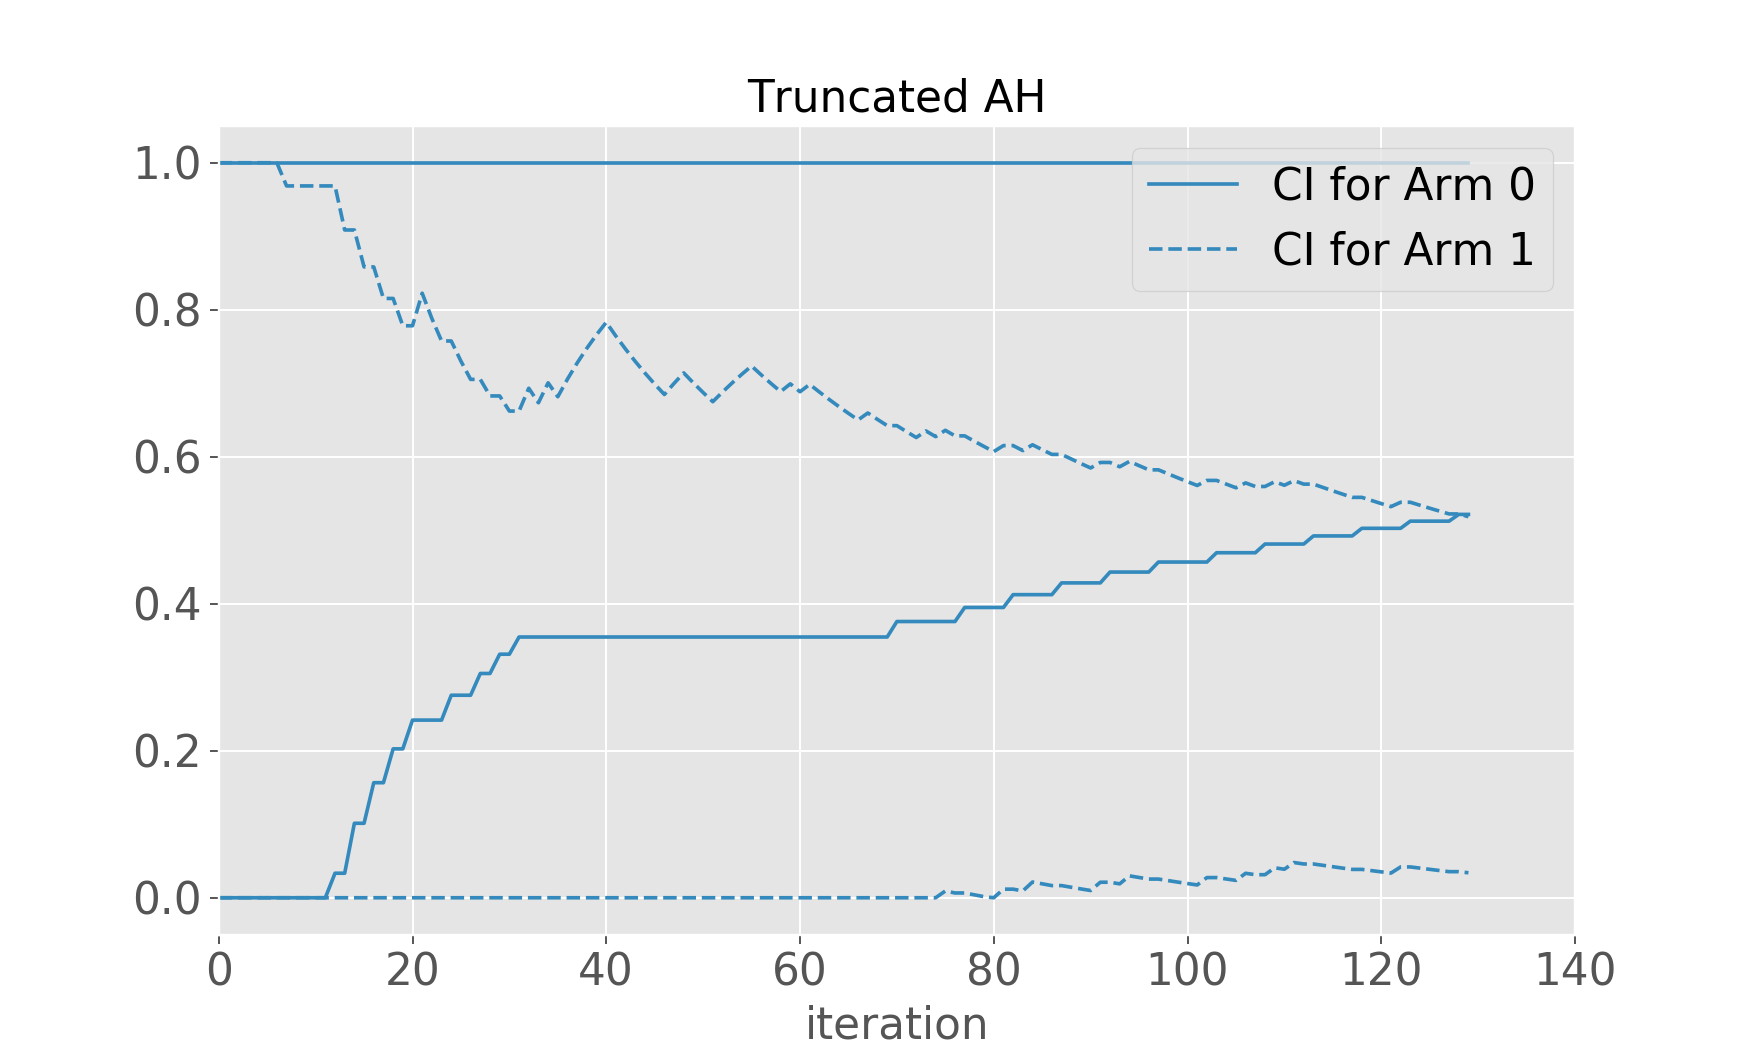

In [149]:
def gen_data_func(mu, n):
    return np.random.binomial(1, p=mu, size=n)

def conf_seq_func_ah_truncated(Y, delta):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_ah = adaptive_hoeffding_seq(N, delta / 2, upper=1, lower=0)
    LB = np.maximum(Ymean - f_ah / ns, 0.0)
    UB = np.minimum(Ymean + f_ah / ns, 1.0)
    #radius = np.maximum(UB - Ymean, Ymean - LB) If you use the original radius you get the better performance.
    radius = (UB - LB) / 2.0
    return LB, UB, radius

def conf_seq_func_ah(Y, delta):
    N = len(Y)
    Sn = np.cumsum(Y)
    ns = np.arange(1, N+1)
    Ymean = Sn / ns
    f_ah = adaptive_hoeffding_seq(N, delta / 2, upper=1, lower=0)
    return Ymean - f_ah / ns, Ymean + f_ah / ns, f_ah/ ns

K=2
max_pull=600
mus = np.zeros(K)
for ii in range(K):
    mus[ii] = 1.0 - (ii / float(K))**0.6
np.random.seed(0)
Ys = [gen_data_func(mus[ii], max_pull) for ii in range(K)]
_, _, pulls, _, L, U, R,  = best_arm(Ys, conf_seq_func_ah, delta=0.05)
_, _, pulls1, _, L1, U1, R1 = best_arm(Ys, conf_seq_func_ah_truncated, delta=0.05)  


plt.style.use('ggplot')

ind_arm0 = np.where(pulls<1)[0]
ind_arm1 = np.where(pulls)[0]
fig = plt.figure(figsize=[10, 6])
plt.plot(ind_arm0, [-0.2] * ind_arm0.size, '.', color='r',alpha=0.5,markersize=8, label='Arm 0 (AH)')
plt.plot(ind_arm1, [-0.2] * ind_arm1.size, '+', color='r',markersize=20, label='Arm 1 (AH)')

ind_arm0 = np.where(pulls1<1)[0]
ind_arm1 = np.where(pulls1)[0]
plt.plot(ind_arm0, [-0.5] * ind_arm0.size, '.', color='C1',markersize=8, label='Arm 0 (Truncated AH)')
plt.plot(ind_arm1, [-0.5] * ind_arm1.size, '+', color='C1', markersize=20, label='Arm 1 (Truncated AH)')
plt.ylim([-1, 0.5])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.gca().axes.yaxis.set_ticks([])
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Pulled Arm', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_pulled_arm_ah.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(R[0], color='C0', label='Arm 0 (AH)')
plt.plot(R[1], color='C0', linestyle='--', label='Arm 1 (AH)')
plt.plot(R1[0], color='C1',label='Arm 0 (Truncated AH)')
plt.plot(R1[1], color='C1', linestyle='--', label='Arm 1 (Truncated AH)')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Radius', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_radius_ah.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(R[0] - R[1], label='AH')
plt.plot(R1[0] - R1[1], label='Truncated AH')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Radius Difference', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_radius_diff_ah.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(L[0], 'C0', label='CI for Arm 0')
plt.plot(U[0], 'C0')
plt.plot(L[1], 'C0', linestyle='--', label='CI for Arm 1')
plt.plot(U[1], 'C0', linestyle='--')
plt.xlabel('iteration', fontsize=18)
plt.title('AH', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim([0, 140])
plt.savefig('./figure/best_arm_confseq_ah.pdf', bbox_inches='tight', pad_inches=0)

plt.figure(figsize=[10, 6])
plt.plot(L1[0], 'C1', label='CI for Arm 0')
plt.plot(U1[0], 'C1')
plt.plot(L1[1], 'C1', linestyle='--', label='CI for Arm 1')
plt.plot(U1[1], 'C1', linestyle='--')
plt.xlabel('iteration', fontsize=18)
plt.title('Truncated AH', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim([0, 140])
plt.savefig('./figure/best_arm_confseq_ah_truncated.pdf', bbox_inches='tight', pad_inches=0)

## Bentkus vs Original Bentkus

Iter 49, Arm 1 out
Iter 116, Arm 1 out


<IPython.core.display.Javascript object>


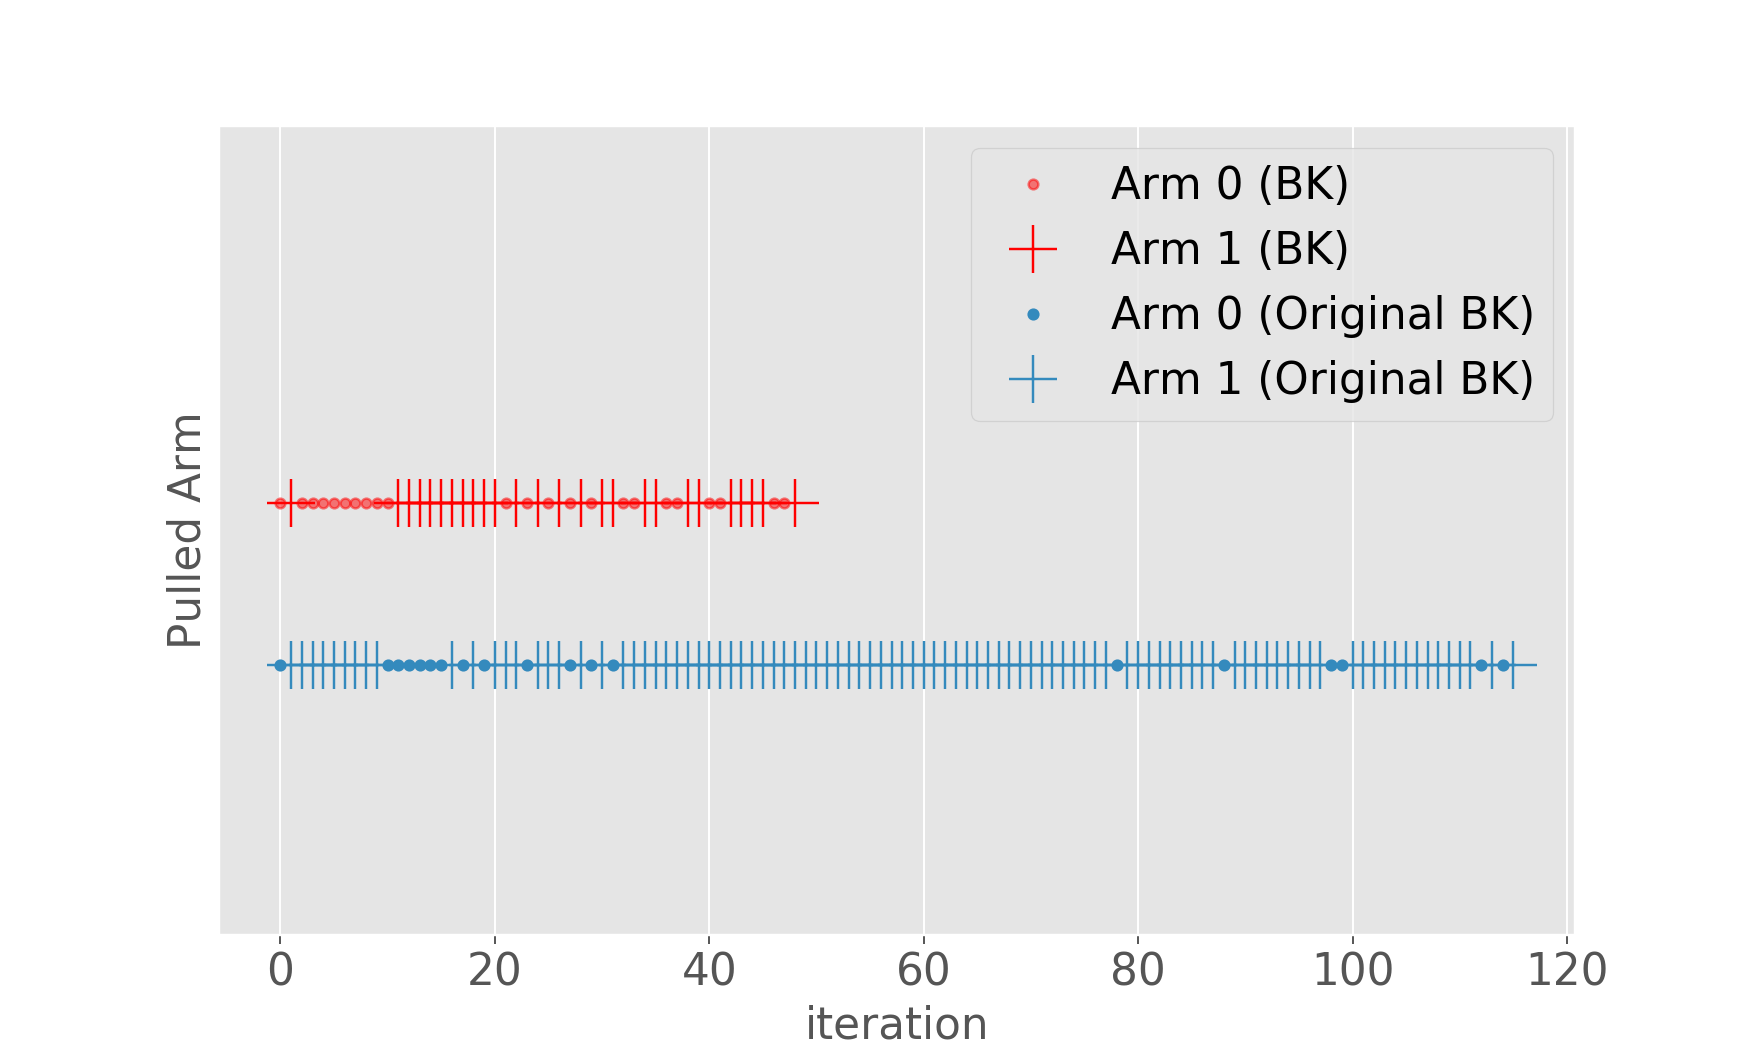

<IPython.core.display.Javascript object>


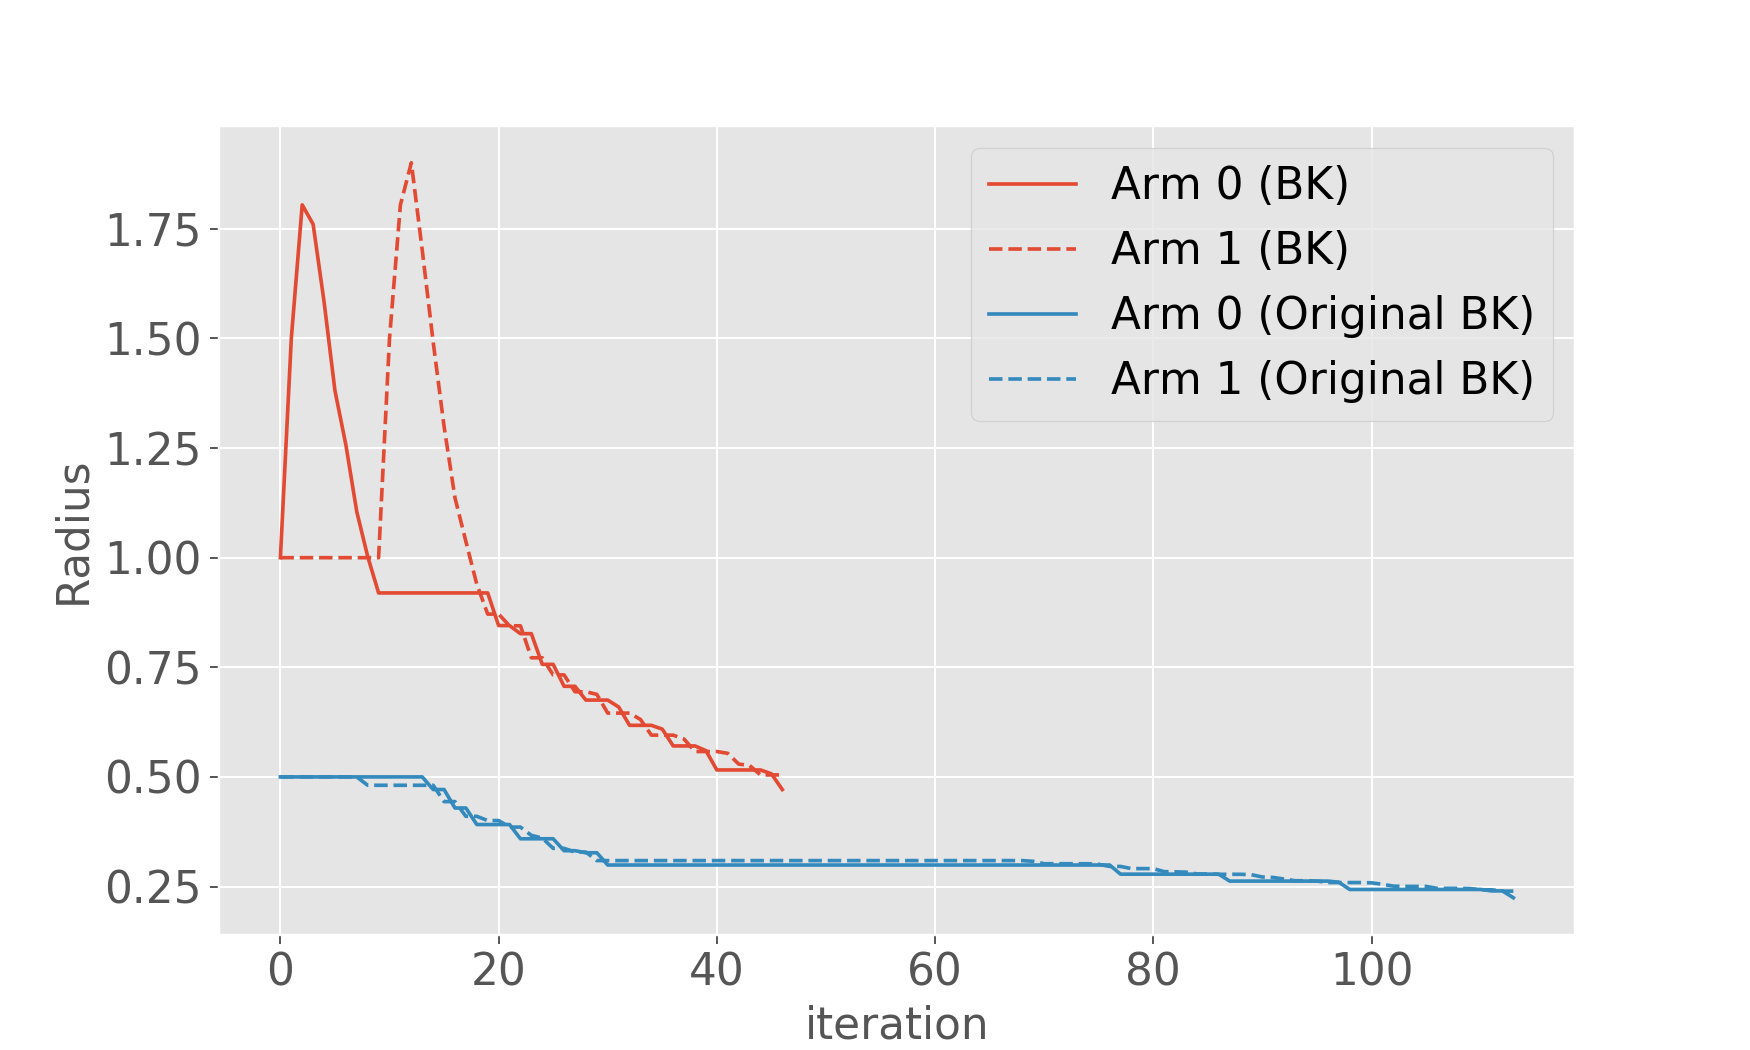

<IPython.core.display.Javascript object>


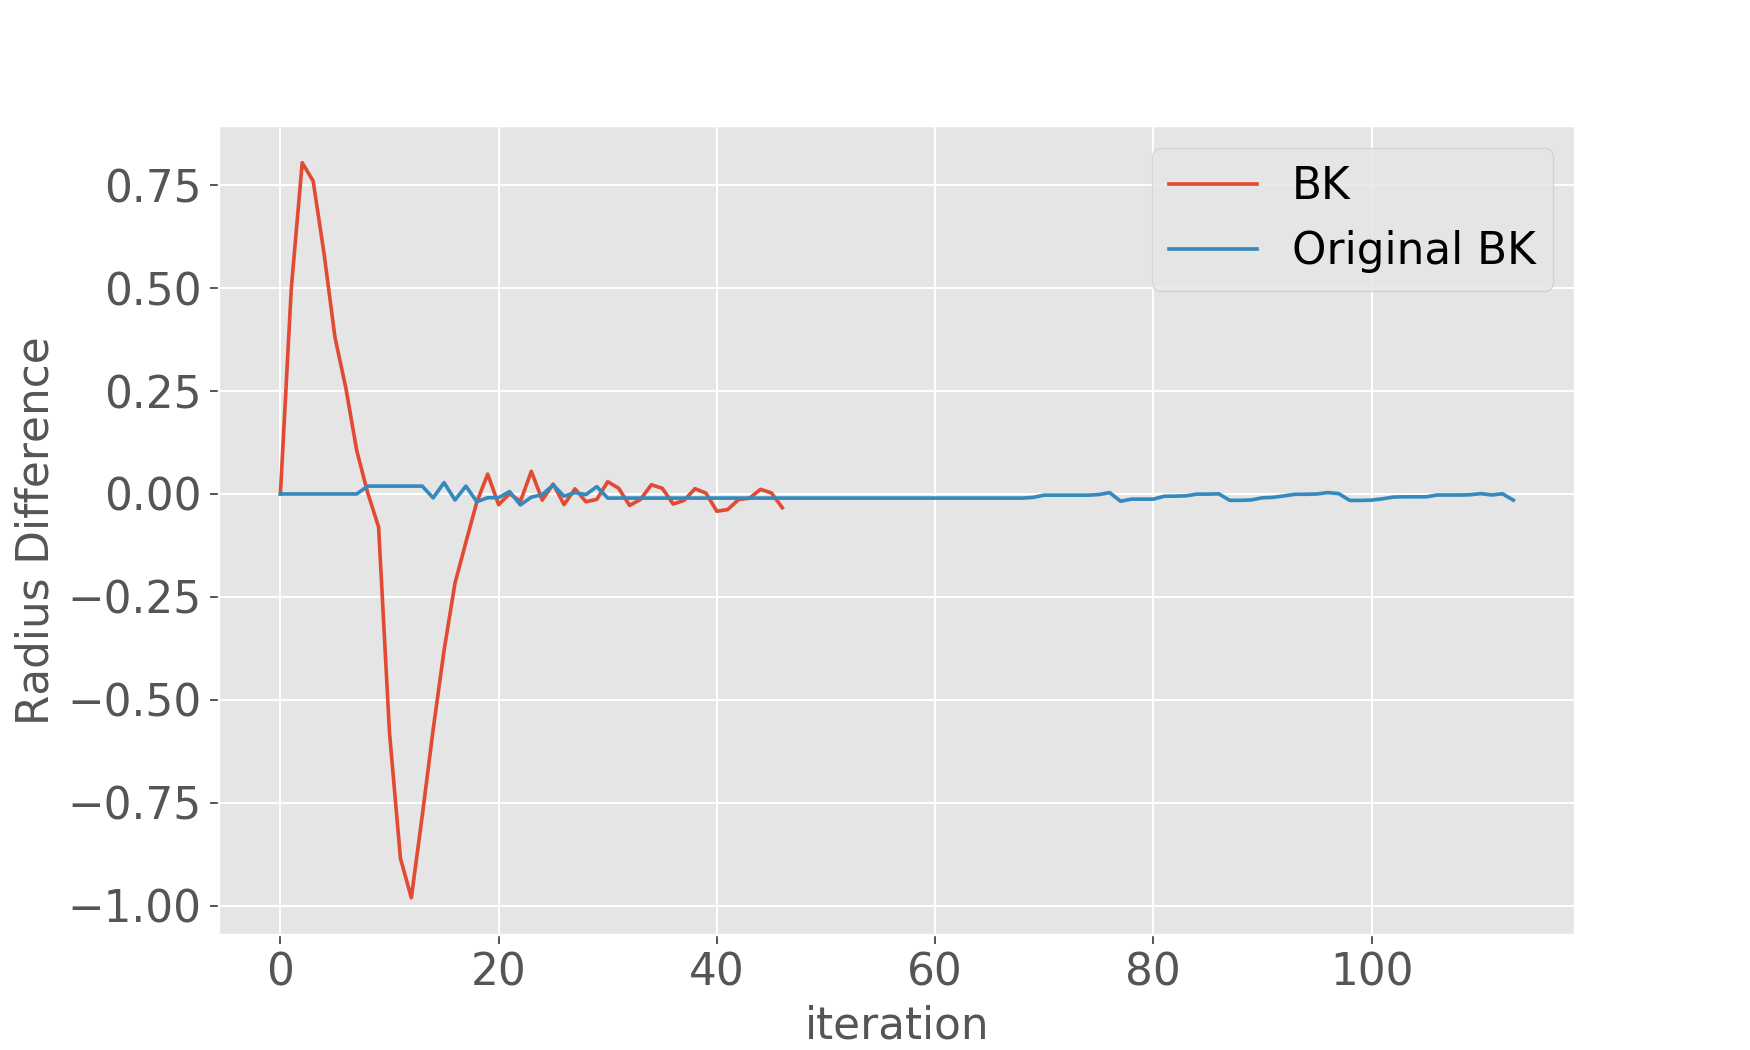

<IPython.core.display.Javascript object>


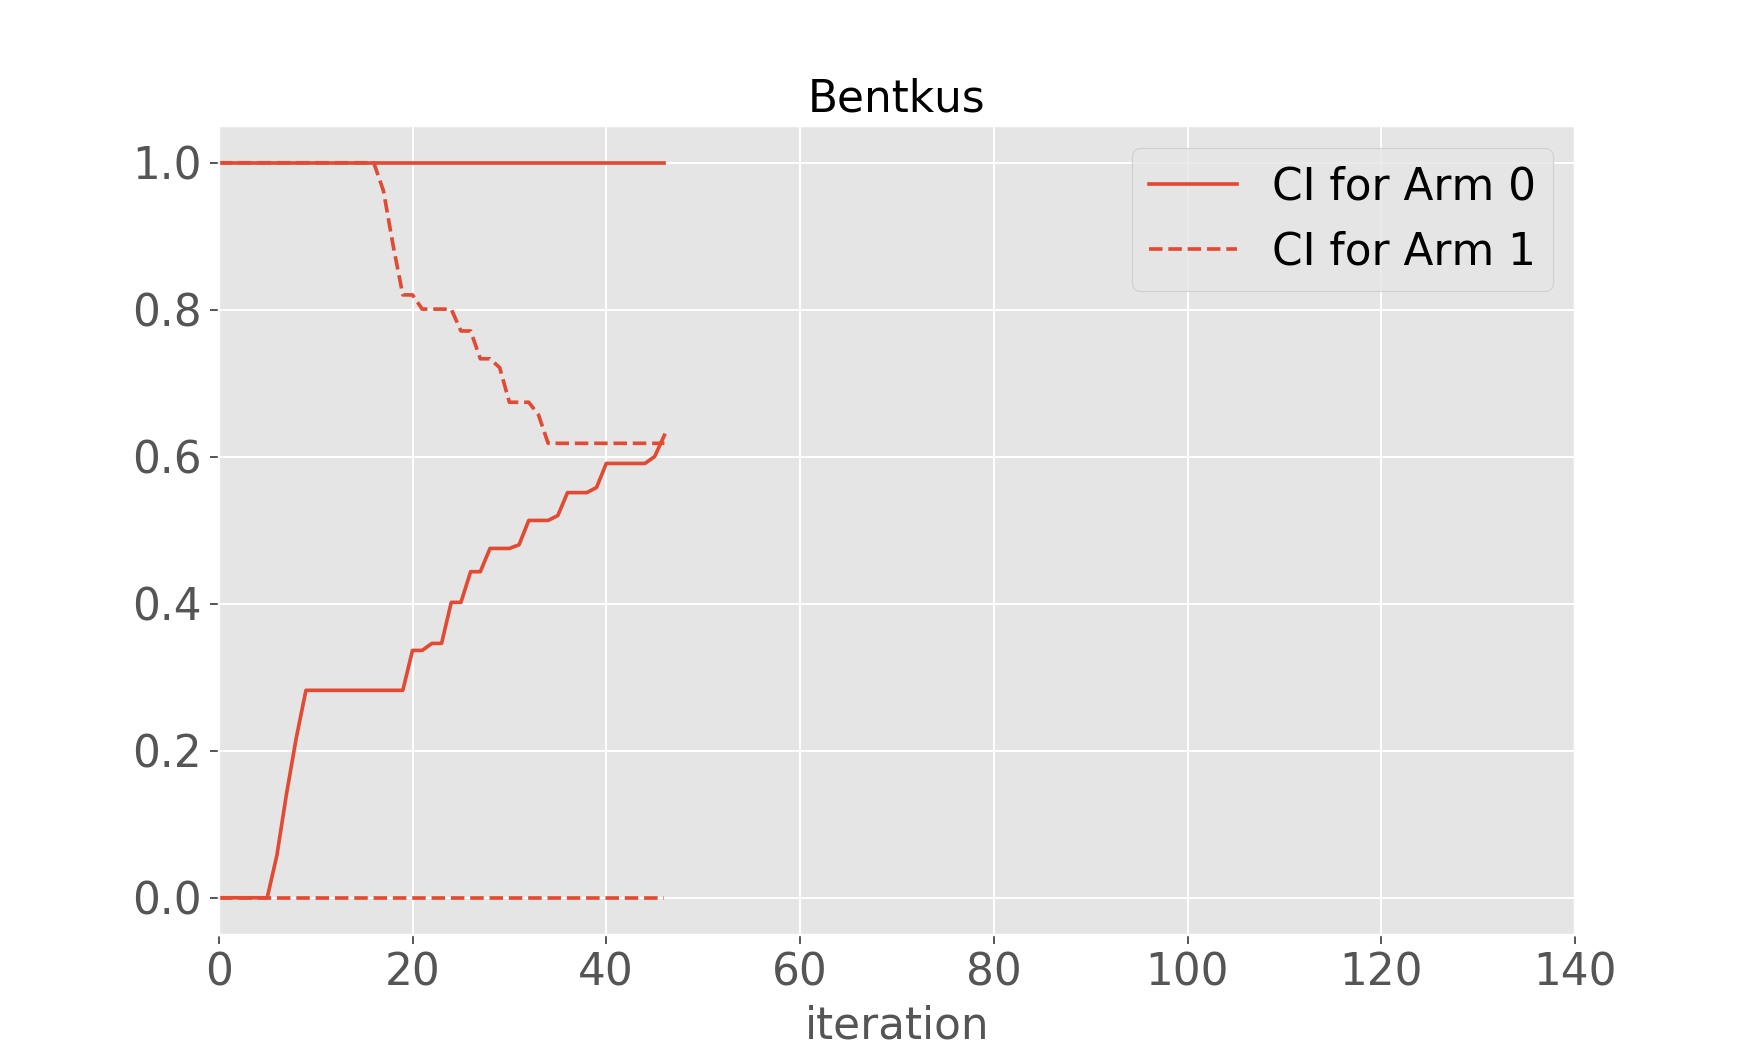

<IPython.core.display.Javascript object>


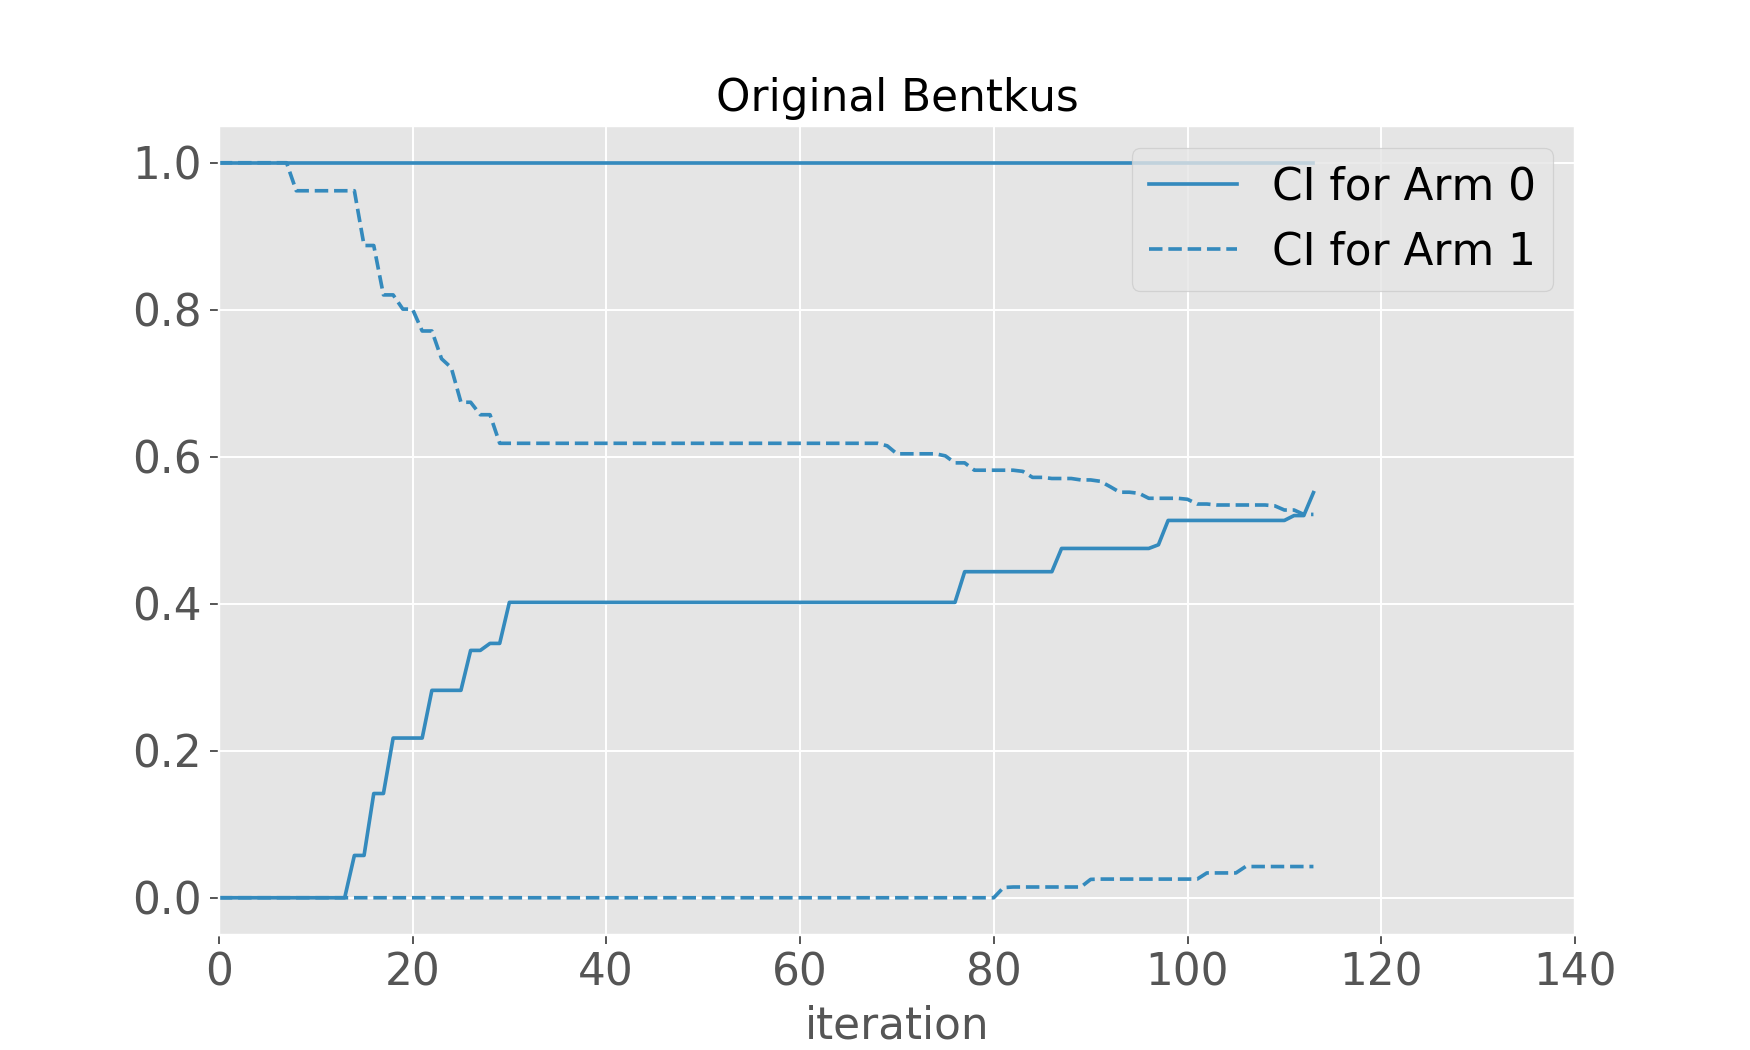

In [150]:
def gen_data_func(mu, n):
    return np.random.binomial(1, p=mu, size=n)

def conf_seq_func_bk_variation(Y, delta, eta=1.1, power=1.1):
    mu_low, mu_up, Sn_low, Sn_up = adaptive_bentkus_seq(Y, delta, U=1, L=0, eta=eta, power=power)
    LL, UU, _, _ = adaptive_bentkus_seq_untruncated(Y, delta, U=1, L=0, eta=eta, power=power)
    return mu_low, mu_up, (UU - LL)/2.0

def conf_seq_func_bk(Y, delta, eta=1.1, power=1.1):
    mu_low, mu_up, Sn_low, Sn_up = adaptive_bentkus_seq(Y, delta, U=1, L=0, eta=eta, power=power)
    return mu_low, mu_up, (mu_up - mu_low)/2.0


K=2
max_pull=600
mus = np.zeros(K)
for ii in range(K):
    mus[ii] = 1.0 - (ii / float(K))**0.6
np.random.seed(0)
Ys = [gen_data_func(mus[ii], max_pull) for ii in range(K)]
_, _, pulls, _, L, U, R,  = best_arm(Ys, conf_seq_func_bk_variation, delta=0.05)
_, _, pulls1, _, L1, U1, R1 = best_arm(Ys, conf_seq_func_bk, delta=0.05)  


plt.style.use('ggplot')
ind_arm0 = np.where(pulls<1)[0]
ind_arm1 = np.where(pulls)[0]
fig = plt.figure(figsize=[10, 6])
plt.plot(ind_arm0, [-0.2] * ind_arm0.size, '.', color='r',alpha=0.5,markersize=8, label='Arm 0 (BK)')
plt.plot(ind_arm1, [-0.2] * ind_arm1.size, '+', color='r',markersize=20, label='Arm 1 (BK)')

ind_arm0 = np.where(pulls1<1)[0]
ind_arm1 = np.where(pulls1)[0]
plt.plot(ind_arm0, [-0.5] * ind_arm0.size, '.', color='C1',markersize=8, label='Arm 0 (Original BK)')
plt.plot(ind_arm1, [-0.5] * ind_arm1.size, '+', color='C1', markersize=20, label='Arm 1 (Original BK)')
plt.ylim([-1, 0.5])
plt.tick_params(axis='both', which='major', labelsize=18)
plt.gca().axes.yaxis.set_ticks([])
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Pulled Arm', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_pulled_arm_bk.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(R[0], color='C0', label='Arm 0 (BK)')
plt.plot(R[1], color='C0', linestyle='--', label='Arm 1 (BK)')
plt.plot(R1[0], color='C1',label='Arm 0 (Original BK)')
plt.plot(R1[1], color='C1', linestyle='--', label='Arm 1 (Original BK)')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Radius', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_radius_bk.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(R[0] - R[1], label='BK')
plt.plot(R1[0] - R1[1], label='Original BK')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlabel('iteration', fontsize=18)
plt.ylabel('Radius Difference', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.savefig('./figure/best_arm_radius_diff_bk.pdf', bbox_inches='tight', pad_inches=0)


fig = plt.figure(figsize=[10, 6])
plt.plot(L[0], 'C0', label='CI for Arm 0')
plt.plot(U[0], 'C0')
plt.plot(L[1], 'C0', linestyle='--', label='CI for Arm 1')
plt.plot(U[1], 'C0', linestyle='--')
plt.xlabel('iteration', fontsize=18)
plt.title('Bentkus', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim([0, 140])
plt.savefig('./figure/best_arm_confseq_bk.pdf', bbox_inches='tight', pad_inches=0)

plt.figure(figsize=[10, 6])
plt.plot(L1[0], 'C1', label='CI for Arm 0')
plt.plot(U1[0], 'C1')
plt.plot(L1[1], 'C1', linestyle='--', label='CI for Arm 1')
plt.plot(U1[1], 'C1', linestyle='--')
plt.xlabel('iteration', fontsize=18)
plt.title('Original Bentkus', fontsize=18)
plt.legend(fontsize=18, loc='upper right')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.xlim([0, 140])
plt.savefig('./figure/best_arm_confseq_bk_truncated.pdf', bbox_inches='tight', pad_inches=0)